In [5]:
# RUN THIS CELL FIRST!

import cv2
import numpy as np
import os
import xml.dom.minidom
import shutil
import zipfile
from matplotlib import pyplot as plt
from PIL import Image

In [10]:
#-------PARAMS-------
readEncoding = 'UTF-8'
writeEncoding = 'UTF-8'
imgpathnoBBU = r'/root/CMDI_data/image_noBBU/'
annopathnoBBU = r'/root/CMDI_data/xml_noBBU/'
#--------------------

def readFile(filename, rEncoding):
    with open(filename, 'r', encoding=f'{rEncoding}') as f:
        data = f.read()
        f.close()
    dom = xml.dom.minidom.parseString(data)
    return dom

def writeFile(dom, filename, wEncoding):
    with open(filename, 'w') as f:
        dom.writexml(f, addindent='  ', encoding=f'{wEncoding}')
        f.close()
    return

# (1) fit all annotation to width: 540, height: 960, transform bounding boxes, then resize images to width: 540, height: 960
def resize(imgname, annoname):
    dom = readFile(annoname, readEncoding)
    t = Image.open(imgname)
    collection = dom.documentElement
    objectlist = collection.getElementsByTagName('object')
    size = collection.getElementsByTagName('size')
    width = int(size[0].childNodes[1].childNodes[0].nodeValue)
    height = int(size[0].childNodes[3].childNodes[0].nodeValue)
    
    if width == 960:
        for obj in objectlist:
            name = obj.getElementsByTagName('name')[0].childNodes[0].data
            if name == '接地': continue
            
            box = obj.getElementsByTagName('bndbox')[0]
            xmin = int(box.getElementsByTagName('xmin')[0].childNodes[0].data)
            ymin = int(box.getElementsByTagName('ymin')[0].childNodes[0].data)
            xmax = int(box.getElementsByTagName('xmax')[0].childNodes[0].data)
            ymax = int(box.getElementsByTagName('ymax')[0].childNodes[0].data)
            
            box.getElementsByTagName('xmin')[0].childNodes[0].data = str(max(0, 540 - ymax))
            box.getElementsByTagName('xmax')[0].childNodes[0].data = str(min(540, 540 - ymin))
            box.getElementsByTagName('ymin')[0].childNodes[0].data = str(max(0, xmin))
            box.getElementsByTagName('ymax')[0].childNodes[0].data = str(min(960, xmax))
            
        collection.getElementsByTagName('width')[0].childNodes[0].data = str(540)
        collection.getElementsByTagName('height')[0].childNodes[0].data = str(960)
        writeFile(dom, annoname, writeEncoding)
    else:
        for obj in objectlist:
            name = obj.getElementsByTagName('name')[0].childNodes[0].data
            if name == '接地': continue
            
            box = obj.getElementsByTagName('bndbox')[0]
            xmin = int(box.getElementsByTagName('xmin')[0].childNodes[0].data)
            ymin = int(box.getElementsByTagName('ymin')[0].childNodes[0].data)
            xmax = int(box.getElementsByTagName('xmax')[0].childNodes[0].data)
            ymax = int(box.getElementsByTagName('ymax')[0].childNodes[0].data)
            
            if xmin < 0 or ymin < 0 or xmax > 540 or ymax > 960:
                    print(f'checked {annoname}')
                    if xmin < 0:
                        box.getElementsByTagName('xmin')[0].childNodes[0].data = str(0)
                    if ymin < 0:
                        box.getElementsByTagName('ymin')[0].childNodes[0].data = str(0)
                    if xmax > 540:
                        box.getElementsByTagName('xmax')[0].childNodes[0].data = str(540)
                    if ymax > 960:
                        box.getElementsByTagName('ymax')[0].childNodes[0].data = str(960)
        collection.getElementsByTagName('width')[0].childNodes[0].data = str(540)
        collection.getElementsByTagName('height')[0].childNodes[0].data = str(960)
        writeFile(dom, annoname, writeEncoding) 
    t.resize((540, 960), resample = 2).save(imgname, quality = 95)
    return

# (2) move out image-annotation pairs without BBU devices
def clean(image, annoname):
    dom = readFile(annoname, readEncoding)
    collection = dom.documentElement
    objectlist = collection.getElementsByTagName('object')
    objectname = []
    
    for i in range(len(objectlist)):
        objectname.append(objectlist[i].childNodes[1].childNodes[0].nodeValue)
    if 'BBU' not in objectname:
        imgsrc = imgname
        imgdst = imgpathnoBBU
        annosrc = annoname
        annodst = annopathnoBBU
        shutil.move(imgsrc, imgdst)
        shutil.move(annosrc, annodst)
        print(f'MOVED {image}')
    return

def printDataset(imgpath, annopath):
    imglist = os.listdir(imgpath)
    for image in imglist:
        imgname = imgpath + image
        annoname = annopath + image.replace('.jpg','.xml')
        if annoname == f'{annopath}.ipynb_checkpoints': return
        dom = readFile(annoname, readEncoding)
        
        collection = dom.documentElement
        objectlist = collection.getElementsByTagName('object')
        size = collection.getElementsByTagName('size')
        width = int(size[0].childNodes[1].childNodes[0].nodeValue)
        height = int(size[0].childNodes[3].childNodes[0].nodeValue)

        imgarray = np.array(Image.open(imgname), dtype = np.uint8)
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        print(imgname)

        for obj in objectlist:
            name = obj.childNodes[1].childNodes[0].nodeValue
            if name == '接地': continue
            elif name == '接地线': continue
            elif name == 'BBU':
                typ = obj.getElementsByTagName("type")[0].childNodes[0].data
                xmin = int(obj.childNodes[11].childNodes[1].childNodes[0].nodeValue)
                ymin = int(obj.childNodes[11].childNodes[3].childNodes[0].nodeValue)
                xmax = int(obj.childNodes[11].childNodes[5].childNodes[0].nodeValue)
                ymax = int(obj.childNodes[11].childNodes[7].childNodes[0].nodeValue)
                # pose = obj.childNodes[5].childNodes[0].nodeValue
                print(typ, xmin, ymin, xmax, ymax)
                '''
                if pose == 'Horizontal': 
                    ax.set_ylabel('Horizontal')
                if pose == 'Vertical': 
                    ax.set_ylabel('Vertical')
                '''
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor = 'red', linewidth=1)
                ax.add_patch(rect)               
        plt.imshow(imgarray)
        plt.show()
    return

In [26]:
# models of BBU: '爱立信BB6648', '中兴V9200', '中兴B8300', '华为BBU5900', '华为BBU3900', '爱立信BB6630', '诺基亚 Airscale', '华为BBU3910', '诺基亚 FSIH'
# size of images: 540 * 960, usually in upright position
# property '接地' has no bounding box

#--------------------PARAMS----------------------
imgpath = r'/root/CMDI_data/image/'
annopath = r'/root/CMDI_data/xml/'
devices = []
sizes = []
truesizes = []
types = ['BBU3900', 'FSIH', 'Airscale', 'BB6648', 'B8300', 'BBU3910', 'BBU5900', 'BB6630', 'V9200']
counts = np.zeros((9, ), dtype = int)
#------------------------------------------------

annolist = os.listdir(annopath)
for annotation in annolist:
        counter = np.zeros((9, ), dtype = int)
        annoname = annopath + annotation
        imgname = annopath.replace('xml','image') + annotation.replace('xml','jpg')
        if annoname == annopath + '.ipynb_checkpoints': continue
        dom = readFile(annoname, readEncoding)
        
        collection = dom.documentElement
        objectlist = collection.getElementsByTagName('object')
        size = collection.getElementsByTagName('size')
        width = int(size[0].childNodes[1].childNodes[0].nodeValue)
        height = int(size[0].childNodes[3].childNodes[0].nodeValue)
        sizes.append((width,height))
        t = Image.open(imgname)
        truesizes.append((t.size[0], t.size[1]))
    
        for i in range(len(objectlist)):
            if objectlist[i].childNodes[1].childNodes[0].nodeValue == '接地': continue
            elif objectlist[i].childNodes[1].childNodes[0].nodeValue == '接地线': continue
            else: 
                deviceName = objectlist[i].childNodes[3].childNodes[0].nodeValue
                devices.append(deviceName)
                if deviceName == '华为BBU3900': counter[0] += 1
                elif deviceName == '诺基亚 FSIH': counter[1] += 1
                elif deviceName == '诺基亚 Airscale': counter[3] += 1
                elif deviceName == '爱立信BB6648': counter[5] += 1
                elif deviceName == '中兴B8300': counter[2] += 1
                elif deviceName == '华为BBU3910': counter[4] += 1
                elif deviceName == '华为BBU5900': counter[6] += 1
                elif deviceName == '爱立信BB6630': counter[7] += 1
                elif deviceName == '中兴V9200': counter[8] += 1
        counts += counter        
print(len(annolist))
print(set(devices))
print(counts, sum(counts))
print(set(sizes))
print(set(truesizes))

2693
{'中兴B8300', '诺基亚 Airscale', '爱立信BB6648', '华为BBU3900', '华为BBU3910', '诺基亚 FSIH', '华为BBU5900', '爱立信BB6630', '中兴V9200'}
[  13   20   33   38   69   96  808 1027 1133] 3237
{(540, 960)}
{(540, 960)}


In [4]:
# change all sizes to width: 540, height: 960
# from dataset removed image-annotation pairs without BBU device

imglist = os.listdir(imgpath)
originalLen = len(imglist)

for image in imglist:
    imgname = imgpath + image
    annoname = annopath + image.replace('.jpg','.xml')
    if annoname == annopath + '.ipynb_checkpoints': continue
    
    resize(imgname, annoname)
    clean(imgname, annoname)
    
print(originalLen - len(os.listdir(imgpath)), len(os.listdir(imgpath)))

checked /root/CMDI_data/xml/100000263_gc4iae2b.xml
MOVED /root/CMDI_data/image/100000263_8kt3y034.jpg
checked /root/CMDI_data/xml/100000263_nefpfb7a.xml
checked /root/CMDI_data/xml/100000263_h42l4h50.xml
checked /root/CMDI_data/xml/100000263_l03g24e8.xml
MOVED /root/CMDI_data/image/100000263_5r4etl6y.jpg
MOVED /root/CMDI_data/image/100000263_nee75841.jpg
MOVED /root/CMDI_data/image/100000263_p5q0u50a.jpg
checked /root/CMDI_data/xml/100000263_h3la7812.xml
checked /root/CMDI_data/xml/100000263_62yq232u.xml
checked /root/CMDI_data/xml/100000263_5248212f.xml
checked /root/CMDI_data/xml/100000263_u6c0mn08.xml
MOVED /root/CMDI_data/image/100000263_6v22v6ud.jpg
checked /root/CMDI_data/xml/100000263_83hw032c.xml
checked /root/CMDI_data/xml/100000263_226q47j1.xml
MOVED /root/CMDI_data/image/100000263_l55umoc1.jpg
checked /root/CMDI_data/xml/100000263_3p0eyt0i.xml
checked /root/CMDI_data/xml/100000263_c50rmb2k.xml
checked /root/CMDI_data/xml/100000263_670roi7n.xml
checked /root/CMDI_data/xml/100

/root/CMDI_data/image/100000263_b11uj182.jpg
爱立信BB6630 238 83 321 836
爱立信BB6630 96 92 176 817


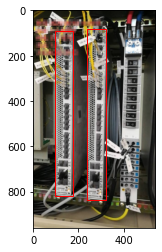

/root/CMDI_data/image/100000263_gc4iae2b.jpg
爱立信BB6630 335 1 501 960


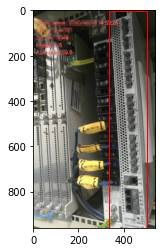

/root/CMDI_data/image/100000263_4140avcf.jpg
中兴V9200 186 95 353 921


KeyboardInterrupt: 

In [12]:
printDataset(r'/root/CMDI_data/image/', r'/root/CMDI_data/xml/')